In [276]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math

data = pd.read_csv('PUBGdata_rå.csv', delimiter=";")
data['kills_per_mand'] = data['kills_total']/data['antal_spillere']
data['spil_farve'] = [
    'green' if i==1
    else 'gold' if i==2
    else 'red' if i==3
    else 'cornflowerblue'
    for i in data['plads']
]

data['spil_størrelse'] = [
    100 if i==1
    else 50 if i==2
    else 30 if i==3
    else 10
    for i in data['plads']
]

data['antal_spillere_farve'] = [
    'r' if i==3
    else 'b' if i==2
    else 's'
    for i in data['antal_spillere']
]

mvgavg = pd.DataFrame(np.transpose(np.convolve(data['kills_per_mand'], np.ones((50,))/50, mode='full')))
data['moving_avg'] = mvgavg

gennemsnit = data.groupby('dag').agg(
    Average_Kills_Per_Mand = ('kills_per_mand','mean'),
    Antal_spil = ('spil',max)
)


data['dailyavg'] = [
    gennemsnit['Average_Kills_Per_Mand'][1] if i==1
    else gennemsnit['Average_Kills_Per_Mand'][2] if i==2
    else gennemsnit['Average_Kills_Per_Mand'][3] if i==3
    else gennemsnit['Average_Kills_Per_Mand'][4] if i==4
    else gennemsnit['Average_Kills_Per_Mand'][5] if i==5
    else gennemsnit['Average_Kills_Per_Mand'][6] if i==6
    else gennemsnit['Average_Kills_Per_Mand'][7] if i==7
    else gennemsnit['Average_Kills_Per_Mand'][8] if i==8
    else gennemsnit['Average_Kills_Per_Mand'][9] if i==9
    else gennemsnit['Average_Kills_Per_Mand'][10] if i==10
    else 0
    for i in data['dag']
]

data


,spil,kills_total,antal_spillere,plads,dag,ekstra_spiller,kills_per_mand,spil_farve,spil_størrelse,antal_spillere_farve,moving_avg,dailyavg
0,1,2,2,0,1,0,1.000000,cornflowerblue,10,b,0.020000,0.857143
1,2,0,2,0,1,0,0.000000,cornflowerblue,10,b,0.020000,0.857143
2,3,2,2,0,1,0,1.000000,cornflowerblue,10,b,0.040000,0.857143
3,4,3,2,0,1,0,1.500000,cornflowerblue,10,b,0.070000,0.857143
4,5,0,2,0,1,0,0.000000,cornflowerblue,10,b,0.070000,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...
196,197,5,3,0,9,kenneth,1.666667,cornflowerblue,10,r,1.383333,1.453333
197,198,3,3,0,9,kenneth,1.000000,cornflowerblue,10,r,1.373333,1.453333
198,199,6,3,0,9,kenneth,2.000000,cornflowerblue,10,r,1.413333,1.453333
199,200,2,3,0,9,kenneth,0.666667,cornflowerblue,10,r,1.396667,1.453333


In [277]:
#OLS med Pythonpakke:
import statsmodels.api as sm

X = sm.add_constant(data['spil'])
model = sm.OLS(data['kills_per_mand'],X)
results = model.fit()
results.params
print(results.summary())
print(np.std(data['kills_per_mand']))

OLS Regression Results                            
Dep. Variable:         kills_per_mand   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     18.33
Date:                Fri, 27 Mar 2020   Prob (F-statistic):           2.89e-05
Time:                        21:09:11   Log-Likelihood:                -268.05
No. Observations:                 201   AIC:                             540.1
Df Residuals:                     199   BIC:                             546.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5133      0.131      3.929      0.000       0.256       0.771
s

0    0.004802
dtype: float64


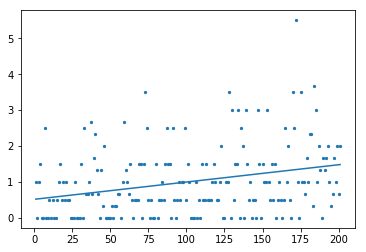

In [284]:
#Prøver at lave OLS manuelt:

#Definerer de kvadrerede afvigelser
gns_y = np.mean(data['kills_per_mand'])
gns_x = np.mean(data['spil'])

afvigelser_y = []
for i in data['kills_per_mand']:
    afvigelser_y.append(i-gns_y)

afvigelser_x = []
for i in data['spil']: 
    afvigelser_x.append(i-gns_x)

df_afvigelser_y = pd.DataFrame(afvigelser_y)
df_afvigelser_x = pd.DataFrame(afvigelser_x)

df_tæller_i = df_afvigelser_x*df_afvigelser_y
df_nævner_i = df_afvigelser_x**2

sum_tæller = np.sum(df_tæller_i)
sum_nævner = np.sum(df_nævner_i)

beta_1 = sum_tæller/sum_nævner

#Prøver at regne intercept:
y_bar = np.mean(data['kills_per_mand'])
x_bar = np.mean(data['spil'])

beta_0 = y_bar - beta_1*x_bar

#Definerer OLS, og plotter:
data['OLS'] = 0.004820*data['spil'] + 0.513317

plt.scatter(data['spil'],data['kills_per_mand'], s=5)
plt.plot(data['spil'],data['OLS'])
plt.show
print(beta_1)

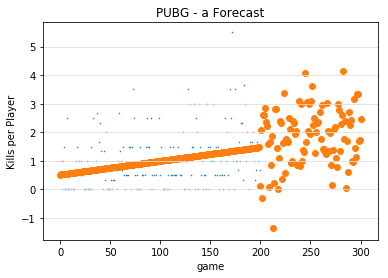

In [285]:
#Lav udvidelse med Slutzky-simulering med stød. Lav 100 simulationer og fremskriv.
#Opstiller model med støddets middelværdi 0, og std.afv. lig regressionens standardafvigelse på spil - så de udsving fortsætter.
def ingen_stød(beta_0,beta_1,x):
    return beta_0 + beta_1*x

def stød(beta_0,beta_1,x,s):
    s = np.random.normal(loc=0,scale=0.95,size=None)
    return beta_0 + beta_1*x + s

#Laver liste med al data (OLS plus random stød i hver periode - skal genskabe ift. sidste periode.)
liste = []
nyliste = []
for i in range(1,201):
    liste.append(ingen_stød(beta_0,beta_1,i))
    nyliste.append(ingen_stød(beta_0,beta_1,i))
for i in range(202,303):
        #s = np.random.normal(loc=0,scale=0.001,size=None) (NORMALFORDELTE STØD)
        liste.append(stød(beta_0,beta_1,i,s))
fremskrivning_x = pd.DataFrame(range(0,301))
fremskrivning_y = pd.DataFrame(liste)


#Fremskriver adderet: 
random = np.random.normal(loc=0,scale=0.90,size=101)
liste1 = pd.DataFrame(np.cumsum(random))
mellem = []
for i in range(202,303):
        mellem.append(ingen_stød(beta_0,beta_1,i))
liste2 = pd.DataFrame(mellem)



#Har nu to lister, som skal i rækkefølge; randomliste og pdnyliste
randomliste = liste1 + liste2
pdnyliste = pd.DataFrame(nyliste)

RandomWalk = pdnyliste.append(randomliste, ignore_index=True)

plt.scatter(data['spil'],data['kills_per_mand'],s=0.3)
#plt.plot(RandomWalk)
plt.scatter(fremskrivning_x,fremskrivning_y)
plt.grid(axis='y',c='gainsboro')
plt.title('PUBG - a Forecast')
plt.xlabel('game')
plt.ylabel('Kills per Player')
plt.show
plt.savefig('Fremskrivning.pdf')


<function matplotlib.pyplot.show(*args, **kw)>

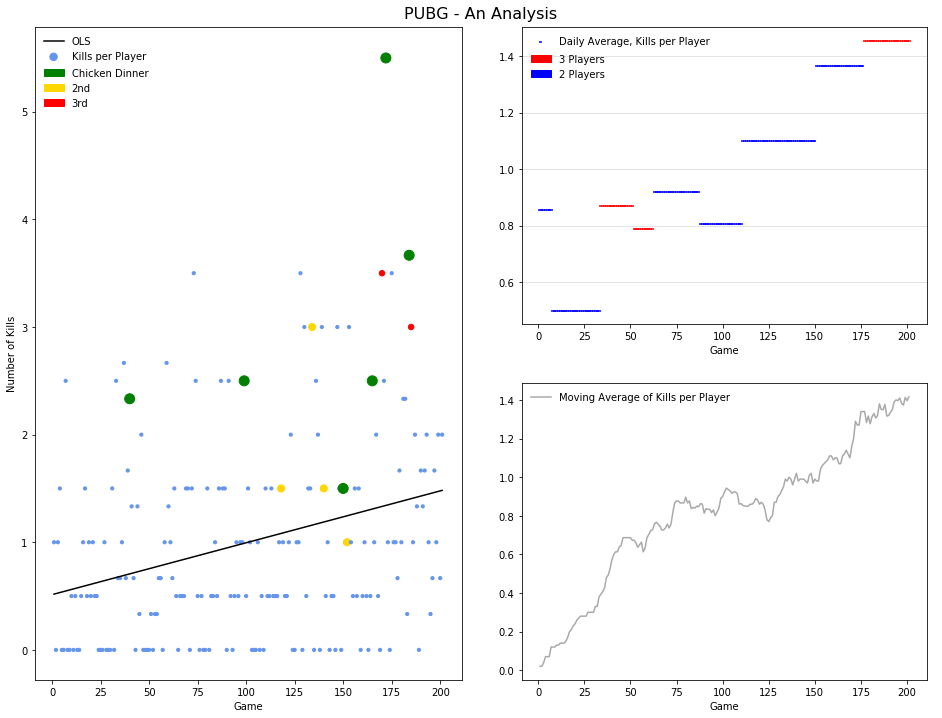

In [286]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

green_patch = mpatches.Patch(color='green', label='Chicken Dinner')
yellow_patch = mpatches.Patch(color='gold', label='2nd')
red_patch = mpatches.Patch(color='red', label='3rd')

#Laver figuren som helhed:
fig = plt.figure(figsize=(16,12), frameon=False)
title_font = {'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
plt.title('PUBG - An Analysis',**title_font)

#Laver figur 1
plt.axis('off')
ax = fig.add_subplot(1,4,(1,2))
plt.scatter(data['spil'],data['kills_per_mand'], s=data['spil_størrelse'], label='Kills per Player', c=data['spil_farve'])
plt.plot(data['spil'],data['OLS'], c='black')
plt.tick_params()
plt.xlabel('Game')
plt.ylabel('Number of Kills')
legend1 = plt.legend(handles=[green_patch,yellow_patch,red_patch], loc='upper left', frameon=False, bbox_to_anchor=(0,0.952))
legend2 = plt.legend(loc='upper left', frameon=False)
ax.add_artist(legend1)

#Laver figur 2:
redpatch = mpatches.Patch(color='r', label='3 Players')
bluepatch = mpatches.Patch(color='b', label='2 Players')

ax = fig.add_subplot(2,2,2)
plt.scatter(data['spil'],data['dailyavg'], s=10, marker='_', label='Daily Average, Kills per Player',c=data['antal_spillere_farve'])
legend1 = plt.legend(handles=[redpatch, bluepatch], loc='upper left', frameon=False, bbox_to_anchor=(0,0.94))
plt.legend(frameon=False)
ax.add_artist(legend1)
plt.grid(axis='y',c='gainsboro')
plt.xlabel('Game')

#Laver figur 3:
ax = fig.add_subplot(2,2,4)
plt.plot(data['spil'],data['moving_avg'],c='darkgrey',label='Moving Average of Kills per Player')

plt.legend(frameon=False)
plt.xlabel('Game')


plt.savefig('Own.pdf')
plt.show



In [287]:
#POISSONESTIMERER MODELLEN:
from scipy import optimize

#Definerer leddene:
n = len(data['kills_per_mand'])
x_sum = sum(data['kills_per_mand'])

data['MLE_mellemregning'] = [
    math.log(math.factorial(round(i)))
    for i in data['kills_per_mand']
]

lnx_sum = sum(data['MLE_mellemregning'])
#Opstiller log-likelihood-funktionen:
#Definerer funktionen, der skal maksimeres (negativt, da den minimeres):
def MLE(lam,n,x_sum,lnx_sum):
    return -(-n*lam + math.log(lam)*x_sum - lnx_sum)


#Definerer minimizeren:
def optimizer(n,x_sum,lnx_sum):
    løsning = optimize.minimize_scalar(
        MLE,method='bounded',
        bounds=(0,100),args=(n,x_sum,lnx_sum))
    return løsning
    theta = løsning.x

theta = optimizer(n,x_sum,lnx_sum)
PUBG_lambda = theta.x
PUBG_lambda
#Nu ouputes parameteren i poissonfordelingen, det ses, at den er lig middelværdien. Yeah boi.

0.9983408530781454

In [288]:
#LAVER POISSONFORDELINGEN (ESTIMERET)

kills_segmentering = data['kills_per_mand'].value_counts()
kills_segmentering_y = list(kills_segmentering)
kills_segmentering_x = list(kills_segmentering.index)



#Definerer, den estimerede poissonfunktion:

def pois(PUBG_lambda,x):
    return ((PUBG_lambda**x)/math.factorial(x))*math.exp(-PUBG_lambda)

pois_vec = []
for i in range(0,16):
    pois_vec.append(pois(PUBG_lambda,i))

x_vec = []
for i in range(0,16):
    x_vec.append(i)

#Laver vektor med pdf-værdier for vores eget data, ud fra segmenteringen (OBS: Kontinuert data, men fordelingen er diskret. Optimalt lagde man vores eget data i diskrete buckets (0,1,2,3 osv), men det orker jeg ikke lige. Derfor bliver vores observations-pdf lavere)
pdf = []
for i in kills_segmentering_y:
    pdf.append(i/sum(kills_segmentering_y))


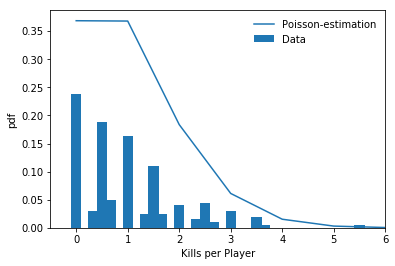

In [289]:
#TEGNER OG BESKRIVER:
data['kills_per_mand'].describe()


graf = plt.figure()
plt.plot(x_vec,pois_vec,label='Poisson-estimation')
plt.bar(kills_segmentering_x,pdf,width=0.2,label='Data')
plt.xlabel('Kills per Player')
plt.ylabel('pdf')
plt.xlim(-0.5,6)
plt.legend(frameon=False)


In [ ]:
facto